# Note
This module is working but currently the first connection time metadata on the FDSN server are incorrect. While the database gets updated, you can use the stationcount-20191109.ipynb notebook (the other one in this repository).

In [64]:
from obspy import read_inventory
from obspy.core.inventory.inventory import Inventory
from obspy.clients.fdsn import Client
from obspy.core import UTCDateTime
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cbook as cbook
import pandas as pd
from pandas import date_range
import numpy as np
import wget, os
import tqdm.notebook as tqdm

years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
days = mdates.MonthLocator()  # every month
years_fmt = mdates.DateFormatter('%Y')
months_fmt = mdates.DateFormatter('%m')

In [100]:
def make_plot(data,
              ymax_mult,
              ymin=0,
              xmin=UTCDateTime(2016,11,1),
              xmax=(UTCDateTime.now()+timedelta(days=60)),
              zeromin=True,
              covid=False,
              active=True):

    try:
        [times, stationcount] = data
    except ValueError:
        times = data.index.date.tolist()
        stationcount = data[0].tolist()

    fig, ax = plt.subplots(figsize=(14, 8))

    plt.ylim(ymin,max(stationcount)*ymax_mult)
    plt.xlim(xmin.datetime,xmax.datetime)
    # titles
    ax.set_xlabel('Time')
    # ticks
    ax.xaxis.set_major_locator(years)
    ax.xaxis.set_major_formatter(years_fmt)
    ax.xaxis.set_minor_locator(months)
    # labels
    ax.format_xdata = mdates.DateFormatter(fmt)
    fig.autofmt_xdate()
    # grid
    plt.grid(b=True, which='major', axis='both', dashes=(1,7))
    if active:
        plt.plot(times, stationcount, label='Online Stations')
        plt.title('Active Raspberry Shake stations over time')
        ax.set_ylabel('Connected stations')
        fn = 'active'
    else:
        plt.plot(times, stationcount, label='Unique Station Connections')
        plt.title('Unique Raspberry Shake data forwarding connections (includes non-active stations)')
        ax.set_ylabel('Unique station connections')
        fn = 'unique'

    # covid-19 delineation
    desc = ''
    if covid:
        plt.axvline(UTCDateTime(2020,3,16).datetime, c='r', label='Work-from-home starts (2020-03-16)')
        plt.axvline(UTCDateTime(2020,5,20).datetime, c='g', label='Shipping begins again (2020-05-20)')
        desc = '-covid'        
        
    plt.legend(loc='upper left')
    fig.savefig('img/%s%s.png' % (fn, desc), bbox_inches='tight')
    plt.show()

    #return fig, ax

def make_lists():
    '''
    gymnastics to create two lists:
    - first connect time
    - stationcount
    '''
    x = [] # list of times for x axis
    d = {} # directory
    # first get earliest starttimes for each entry from obspy station inventory
    for sta in inv[0]:
        d[sta.code] = sta.start_date.datetime
    for sta in inv[0]:
        if d[sta.code] > sta.start_date.datetime:
            d[sta.code] = sta.start_date.datetime

    # create a list of start times and sort
    for s in d:
        x.append(d[s])
    x.sort()

    times, stationcount = [], [] # lists to create/append
    c = 1 # counter
    for s in x:
        stationcount.append(c)
        times.append(s)
        c += 1

    return times, stationcount # x,y

def make_active_lists():
    '''
    gymnastics to create two lists:
    - first connect time
    - stationcount
    
    old method:
    # cull the list to stations active in the last two weeks
    for sta in inv[0]:
        if sta.is_active(starttime=end-timedelta(days=14)):
            pass
        else:
            try:
                del d[sta.code]
            except:
                pass

    '''
    stns, cdates = [], []
    rmdates = ['2019-04-21', '2019-04-22', '2019-05-14', '2020-02-17']
    inv2 = inv.select(time=UTCDateTime.now())
    for stn in inv[0]:#2[0]:
        stns.append(stn.code)
        #s = inv.select(station=stn.code)
        #cdates.append(UTCDateTime(s[0][-1].creation_date))
    stns = np.unique(stns)
    
    times, stationcount = [], [] # lists to create/append

    stime = UTCDateTime(2016, 11, 20)
    etime = UTCDateTime.now()
    step = timedelta(hours=12)
    
    #dates = tqdm.tqdm(date_range(stime.datetime, etime.datetime).tolist())
    stns = tqdm.tqdm(stns)

    t = date_range(start=datetime(2016, 11, 20), end=datetime.now())
    data = np.zeros(len(t))
    df = pd.DataFrame(index=t, data=data)
    df.index = pd.to_datetime(df.index)
    
    for stn in stns:
        st = inv.select(station=stn)
        for epoch in st[0]:
            if epoch.end_date:
                end = epoch.end_date.datetime.strftime('%Y-%m-%d')
            else:
                end = etime.datetime.strftime('%Y-%m-%d')
            if end not in rmdates:
                df.loc[epoch.start_date.strftime('%Y-%m-%d'):end] += 1

    times = df.index.date.tolist()
    stationcount = df[0].tolist()

#     count = 0
#     for t in dates:
#         i = 0
#         times.append(t)
#         for stn in stns:
#             if cdates[i] <= t:
#                 count += 1
#                 stns.remove(stn)
#                 del cdates[i]
#             i += 1
#         stationcount.append(count)

#     count = 0
#     for t in dates:
#         times.append(t)
#         try:
#             for stn in stns:
#                 s = inv.select(station=stn)
#                 cd = UTCDateTime(s[0][-1].creation_date)
#                 if (cd <= t):
#                     count += 1
#                     stns.remove(stn)
#         except IndexError:
#             pass
#         stationcount.append(count)
    
    return df

In [3]:
# set data start/end times
fmt = '%Y-%m-%dT%H:%M:%S'.replace(':','%%3A') # (YYYY, m, d, H, M, S)
start = UTCDateTime(2016, 12, 1, 0, 0, 0)
end = UTCDateTime.now()
s = start.datetime.strftime(fmt)
e = end.datetime.strftime(fmt)

# set channels (comma separated list)
ch = '?HZ'.replace(',', '%2C')

In [4]:
# get inventory
query = 'https://fdsnws.raspberryshakedata.com/fdsnws/station/1/query?channel=%s&formatted=true&nodata=404' % (ch)
tmp = 'inventory.xml'
print('Downloading inventory from:\n%s' % query)
os.remove(tmp) if os.path.isfile(tmp) else ''
tmp = wget.download(query, out=tmp)

https://fdsnws.raspberryshakedata.com/fdsnws/station/1/query?channel=?HZ&formatted=true&nodata=404


In [5]:
# Read in the file
with open(tmp, 'r') as file :
  filedata = file.read()

# Replace the target string
# necessary temporarily because of a bad latitude value
filedata = filedata.replace('6413617054', '64.13617054')

# Write the file out again
with open(tmp, 'w') as file:
  file.write(filedata)

In [6]:
print('Reading inventory')
inv = read_inventory(tmp)
#rs = Client('RASPISHAKE')
#inv = rs.get_stations(channel=ch)

Reading inventory


In [7]:
print('Gathering list of unique active stations and dates...')
unique = make_lists()
print('Unique stations: %s' % (max(unique[1])))

print('Curating list of active stations and dates...')

Gathering list of unique active stations and dates...
Unique stations: 2421
Curating list of active stations and dates... (this will go exponentially faster as it progresses):


In [101]:
active = make_active_lists()
print('Currently active stations: %s' % (active.iloc[-1][0]))


Currently active stations: 1141.0


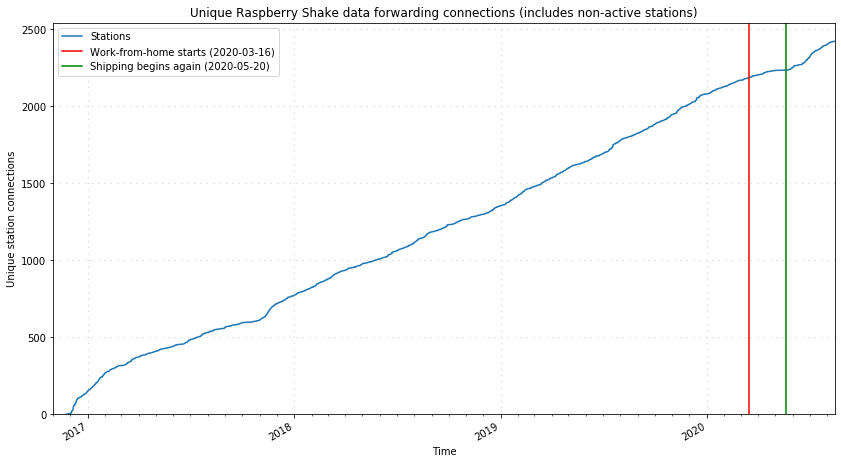

In [26]:
plotstart = UTCDateTime(start)-timedelta(days=30)
plotend = UTCDateTime.now()
#ymin = 2050
#ymax = 2250
ymax_mult = 1.05

make_plot(data=unique, ymax_mult=ymax_mult, xmin=plotstart,
          xmax=plotend, active=False, covid=True)

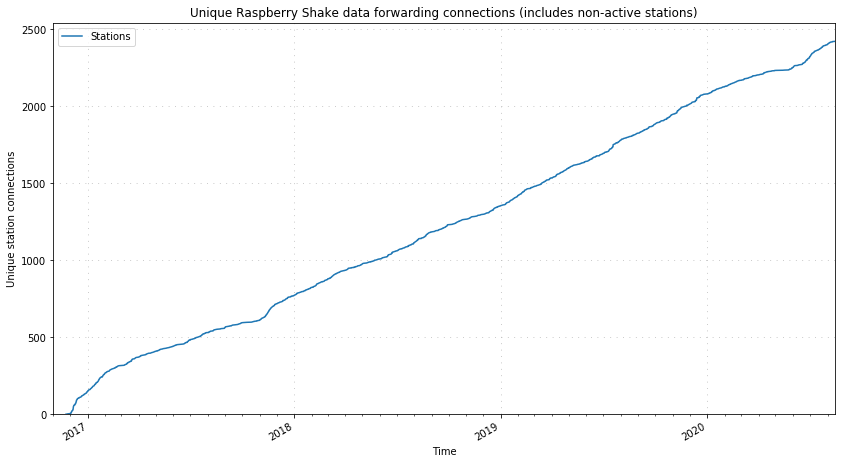

In [10]:
plotstart = UTCDateTime(start)-timedelta(days=30)
plotend = UTCDateTime.now()
#ymin = 2050
#ymax = 2250
ymax_mult = 1.05

make_plot(data=unique, ymax_mult=ymax_mult, xmin=plotstart,
          xmax=plotend, active=False, covid=False)

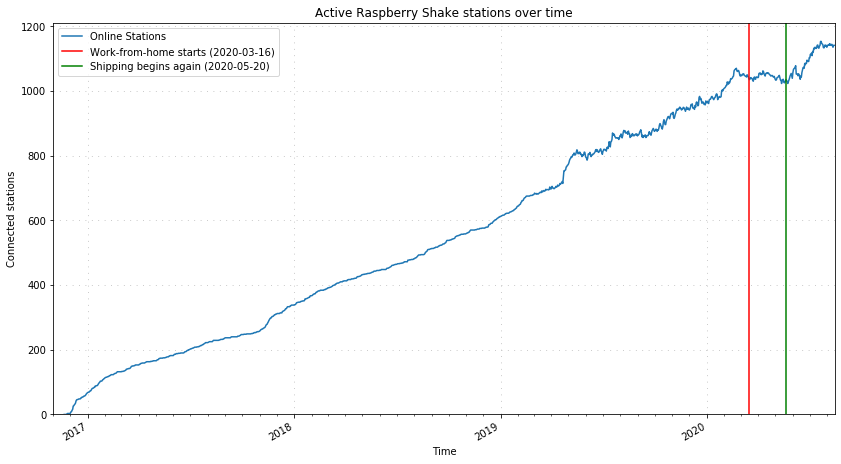

In [102]:
plotstart = UTCDateTime(start)-timedelta(days=30)
plotend = UTCDateTime.now()
#ymin = 2050
#ymax = 2250
ymax_mult = 1.05

make_plot(data=active, ymax_mult=ymax_mult, xmin=plotstart,
          xmax=plotend, active=True, covid=True)

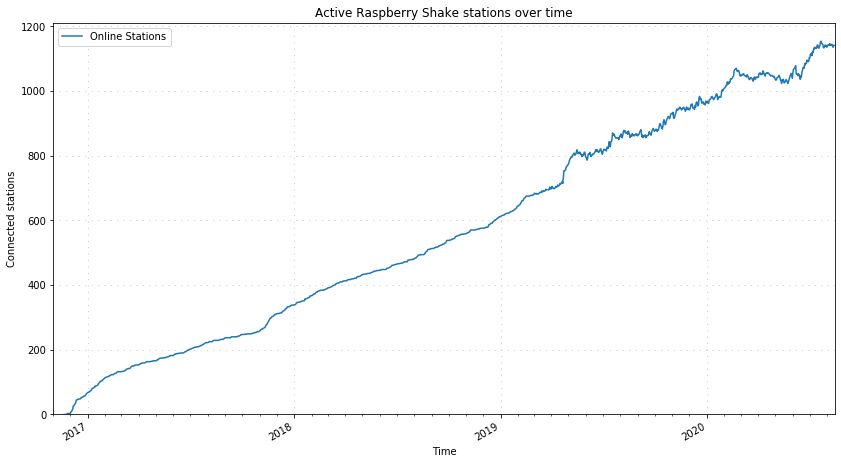

In [103]:
plotstart = UTCDateTime(start)-timedelta(days=30)
plotend = UTCDateTime.now()
#ymin = 2050
#ymax = 2250
ymax_mult = 1.05

make_plot(data=active, ymax_mult=ymax_mult, xmin=plotstart,
          xmax=plotend, active=True, covid=False)

In [99]:
active['2020-01-29':'2020-03-01']

,0
2020-01-29,1103.0
2020-01-30,1109.0
2020-01-31,1111.0
2020-02-01,1116.0
2020-02-02,1117.0
2020-02-03,1121.0
2020-02-04,1126.0
2020-02-05,1126.0
2020-02-06,1139.0
2020-02-07,1135.0


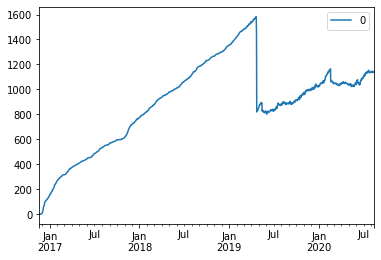

In [74]:
active.plot()